# DSX Analysis

In [49]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb

# Setup notebook
name = '2018-02-26_dsx_analysis'
subproj = '../dsx_ovary_testis_scRNAseq'

nbo1 = Nb.setup_notebook(name, subproject_dir=subproj, seurat_dir='../output/ovary1_scRNAseq')
nbo2 = Nb.setup_notebook(name, subproject_dir=subproj, seurat_dir='../output/ovary2_scRNAseq', watermark=False)
nbo3 = Nb.setup_notebook(name, subproject_dir=subproj, seurat_dir='../output/ovary3_scRNAseq', watermark=False)
nbt1 = Nb.setup_notebook(name, subproject_dir=subproj, seurat_dir='../output/testis1_scRNAseq', watermark=False)
nbt2 = Nb.setup_notebook(name, subproject_dir=subproj, seurat_dir='../output/testis2_scRNAseq', watermark=False)
nbt3 = Nb.setup_notebook(name, subproject_dir=subproj, seurat_dir='../output/testis3_scRNAseq', watermark=False)

last updated: 2018-02-27 
Git hash: c16a3fbdb5e6ad45bca946a0897b9f22fbfba35c


## Data Prep

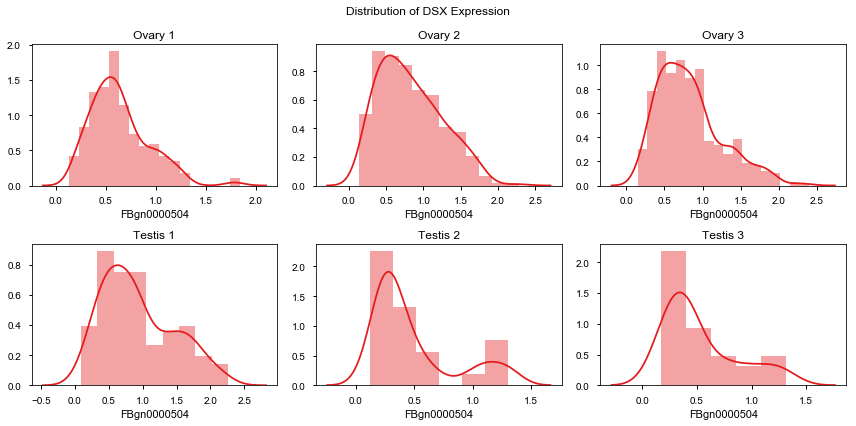

In [115]:
# Figure out which cellids are dsx positive

def get_norm(nb, ax, sample):
    title = {
        'o1': 'Ovary 1',
        'o2': 'Ovary 2',
        'o3': 'Ovary 3',
        't1': 'Testis 1',
        't2': 'Testis 2',
        't3': 'Testis 3',
    }
    
    name = {
        'o1': 'ovary1',
        'o2': 'ovary2',
        'o3': 'ovary3',
        't1': 'testis1',
        't2': 'testis2',
        't3': 'testis3',
    }
    
    dsx = nb.symbol2fbgn['dsx']
    norm = nb.seurat.get_normalized_read_counts()
    dsx_cellid = norm.columns[norm.loc[dsx, :] > 0].tolist()
    
    # Make dist plot
    dsx_dat = norm.loc[dsx, dsx_cellid]
    sns.distplot(dsx_dat, ax=ax)
    ax.set_title(title[sample])
    
    raw = nb.seurat.get_raw()[dsx_cellid].sum(axis=1)
    raw.name = name[sample]
    return raw
    
    
fig, axes = plt.subplots(2, 3, figsize=plt.figaspect(.5))
o1 = get_norm(nbo1, axes[0, 0], 'o1')
o2 = get_norm(nbo2, axes[0, 1], 'o2')
o3 = get_norm(nbo3, axes[0, 2], 'o3')
t1 = get_norm(nbt1, axes[1, 0], 't1')
t2 = get_norm(nbt2, axes[1, 1], 't2')
t3 = get_norm(nbt3, axes[1, 2], 't3')
plt.suptitle('Distribution of DSX Expression')
plt.tight_layout(rect=[0, 0, 1, .95])

In [116]:
# Create raw datatable
dsx_raw = pd.concat([o1, o2, o3, t1, t2, t3], axis=1).fillna(0)

In [117]:
dsx_raw.head()

,ovary1,ovary2,ovary3,testis1,testis2,testis3
FBgn0000008,0.0,0.0,0.0,21.0,3.0,1.0
FBgn0000014,3163.0,4996.0,5728.0,1025.0,150.0,102.0
FBgn0000015,118.0,71.0,114.0,1459.0,99.0,66.0
FBgn0000017,1331.0,1036.0,1617.0,815.0,53.0,40.0
FBgn0000018,31.0,75.0,55.0,26.0,19.0,9.0


In [123]:
# Create metadata table
metadata = pd.DataFrame({
    'samplename': ['ovary1', 'ovary2', 'ovary3', 'testis1', 'testis2', 'testis3'],
    'tissue': ['ovary', 'ovary', 'ovary', 'testis', 'testis', 'testis'],
    'rep': [1, 2, 3, 1, 2, 3],
})

sampletable = metadata[['samplename', 'tissue', 'rep']]

In [124]:
# Output data tables for use with DESeq2
datDir = Path(nbovary.subproject_dir, 'data')
confDir = Path(nbovary.subproject_dir, 'config')
datDir.mkdir(parents=True, exist_ok=True)
confDir.mkdir(parents=True, exist_ok=True)

In [125]:
dsx_raw.to_csv(Path(datDir / 'raw.tsv'), sep='\t')

In [126]:
sampletable.to_csv(Path(confDir / 'sampletable.tsv'), sep='\t', index=False)

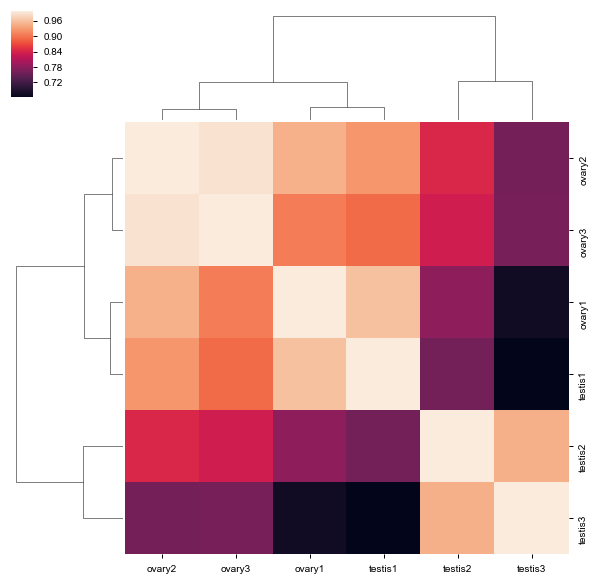

In [127]:
sns.clustermap(dsx_raw.corr())

In [128]:
res = pd.read_csv('../dsx_ovary_testis_scRNAseq/output/ovary_vs_tesits_padj05.tsv', sep='\t')

In [131]:
res['symbol'] = res.FBgn.map(lambda x: nbo1.fbgn2symbol[x])

In [132]:
res.head()

,FBgn,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,symbol
0,FBgn0000008,5.268205,-7.191911,1.864770,-3.856727,1.149152e-04,5.767247e-04,a
1,FBgn0000014,1233.150641,1.573997,0.321308,4.898723,9.646130e-07,8.543599e-06,abd-A
2,FBgn0000015,321.256176,-3.849717,0.679888,-5.662280,1.493750e-08,2.729157e-07,Abd-B
3,FBgn0000028,23.796469,-9.284415,2.271745,-4.086910,4.371566e-05,2.407466e-04,acj6
4,FBgn0000042,12821.873720,1.605150,0.488059,3.288848,1.005984e-03,4.091547e-03,Act5C


In [133]:
res.columns

Index(['FBgn', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj',
       'symbol'],
      dtype='object')

In [137]:
res[['FBgn', 'symbol', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj']].to_csv(
    '../dsx_ovary_testis_scRNAseq/output/ovary_vs_tesits_padj05.tsv', sep='\t', index=False
)

In [141]:
from collections import defaultdict
from goatools.obo_parser import GODag
from goatools import GOEnrichmentStudy
from goatools.mapslim import mapslim
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj

# Slim

In [142]:
# import GO dags
obodag = GODag("../data/external/go-basic.obo")
slimdag = GODag("../data/external/goslim_generic.obo")

load obo file ../data/external/go-basic.obo
../data/external/go-basic.obo: fmt(1.2) rel(2018-02-02) 47,109 GO Terms
load obo file ../data/external/goslim_generic.obo
../data/external/goslim_generic.obo: fmt(1.2) rel(None) 228 GO Terms


In [143]:
# Import fly associations
fly = defaultdict(set)
with open('../data/external/gene_association.fb') as fh:
    for row in fh.readlines():
        if row.startswith('!'):
            continue
        cols = row.split('\t')
        fbgn = cols[1]
        goterm = cols[4]
        gtype = cols[11]
        if gtype != 'protein':
            continue
        if goterm not in obodag:
            continue
        fly[fbgn].add(goterm)

In [144]:
# map them to a slim set
flyslim = defaultdict(set)
for fbgn, goterms in fly.items():
    all_direct_anc = set()
    all_covered_anc = set()
    all_all_anc = set()
    for goterm in goterms:
        direct_anc, all_anc = mapslim(goterm, obodag, slimdag)
        all_all_anc |= all_anc
        # collect all covered ancestors, so the direct ancestors
        # can be calculated afterwards
        all_covered_anc |= (all_anc - direct_anc)
    all_direct_anc = all_all_anc - all_covered_anc
    flyslim[fbgn] |= (all_direct_anc)

In [154]:
with open('../dsx_ovary_testis_scRNAseq/output/background.txt', 'r') as fh:
    bg = [x.strip() for x in fh.readlines()]

goeaobj = GOEnrichmentStudy(
        bg, # Background 
        flyslim, # geneid/GO associations
        slimdag, # Ontologies
        propagate_counts = False,
        alpha = 0.001, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

In [167]:
# Ovary
ovary = res.loc[res.log2FoldChange > 0, 'FBgn'].tolist()
go = goeaobj.run_study(ovary)
go_sig = [r for r in go if r.p_fdr_bh < 0.05]
plot_results("../dsx_ovary_testis_scRNAseq/output/ovary_slim_{NS}.png", go_sig)

Calculating uncorrected p-values using fisher_scipy_stats
   535 out of    615 study items found in association
Running multitest correction: statsmodels fdr_bh
  133 GO terms are associated with 535 of 615 study items
  142 GO terms are associated with 9,728 of 12,420 population items
   26 usr  30 GOs  WROTE: ../dsx_ovary_testis_scRNAseq/output/ovary_slim_BP.png
   10 usr  11 GOs  WROTE: ../dsx_ovary_testis_scRNAseq/output/ovary_slim_CC.png
    9 usr  10 GOs  WROTE: ../dsx_ovary_testis_scRNAseq/output/ovary_slim_MF.png


In [168]:
# Testis
testis = res.loc[res.log2FoldChange < 0, 'FBgn'].tolist()
go = goeaobj.run_study(ovary)
go_sig = [r for r in go if r.p_fdr_bh < 0.05]
plot_results("../dsx_ovary_testis_scRNAseq/output/testis_slim_{NS}.png", go_sig)

Calculating uncorrected p-values using fisher_scipy_stats
   535 out of    615 study items found in association
Running multitest correction: statsmodels fdr_bh
  133 GO terms are associated with 535 of 615 study items
  142 GO terms are associated with 9,728 of 12,420 population items
   26 usr  30 GOs  WROTE: ../dsx_ovary_testis_scRNAseq/output/testis_slim_BP.png
   10 usr  11 GOs  WROTE: ../dsx_ovary_testis_scRNAseq/output/testis_slim_CC.png
    9 usr  10 GOs  WROTE: ../dsx_ovary_testis_scRNAseq/output/testis_slim_MF.png


## FULL

In [169]:
with open('../dsx_ovary_testis_scRNAseq/output/background.txt', 'r') as fh:
    bg = [x.strip() for x in fh.readlines()]

goeaobj = GOEnrichmentStudy(
        bg, # Background 
        fly, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.001, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

fisher module not installed.  Falling back on scipy.stats.fisher_exact
 9,728 out of 12,420 population items found in association


In [170]:
# Ovary
ovary = res.loc[res.log2FoldChange > 0, 'FBgn'].tolist()
go = goeaobj.run_study(ovary)
go_sig = [r for r in go if r.p_fdr_bh < 0.05]
plot_results("../dsx_ovary_testis_scRNAseq/output/ovary_full_{NS}.png", go_sig)

Calculating uncorrected p-values using fisher_scipy_stats
   535 out of    615 study items found in association
Running multitest correction: statsmodels fdr_bh
  2,073 GO terms are associated with 535 of 615 study items
  7,391 GO terms are associated with 9,728 of 12,420 population items
   68 usr 253 GOs  WROTE: ../dsx_ovary_testis_scRNAseq/output/ovary_full_BP.png
   17 usr  55 GOs  WROTE: ../dsx_ovary_testis_scRNAseq/output/ovary_full_CC.png
   15 usr  40 GOs  WROTE: ../dsx_ovary_testis_scRNAseq/output/ovary_full_MF.png


In [171]:
# Testis
testis = res.loc[res.log2FoldChange < 0, 'FBgn'].tolist()
go = goeaobj.run_study(ovary)
go_sig = [r for r in go if r.p_fdr_bh < 0.05]
plot_results("../dsx_ovary_testis_scRNAseq/output/testis_full_{NS}.png", go_sig)

Calculating uncorrected p-values using fisher_scipy_stats
   535 out of    615 study items found in association
Running multitest correction: statsmodels fdr_bh
  2,073 GO terms are associated with 535 of 615 study items
  7,391 GO terms are associated with 9,728 of 12,420 population items
   68 usr 253 GOs  WROTE: ../dsx_ovary_testis_scRNAseq/output/testis_full_BP.png
   17 usr  55 GOs  WROTE: ../dsx_ovary_testis_scRNAseq/output/testis_full_CC.png
   15 usr  40 GOs  WROTE: ../dsx_ovary_testis_scRNAseq/output/testis_full_MF.png
